In [1]:
using Revise

In [2]:
# includet("init.jl")
includet("initpaths.jl")

In [3]:
using GeometryUtils, MeshUtils, CirclePackingUtils, BlochTorreyUtils
using Tensors, JuAFEM, DistMesh
using LinearAlgebra, Statistics
import GreedyCirclePacking, EnergyCirclePacking

In [4]:
function packcircles(btparams::BlochTorreyParameters{T};
        N = 20, # number of circles
        η = btparams.AxonPDensity, # goal packing density
        ϵ = 0.1 * btparams.R_mu, # overlap occurs when distance between circle edges is ≤ ϵ
        α = 1e-1, # covariance penalty weight (enforces circular distribution)
        β = 1e-6, # mutual distance penalty weight
        λ = 1.0, # overlap penalty weight (or lagrange multiplier for constrained version)
        it = 100, # maximum iterations for greedy packing
        maxiter = 5 # maximum attempts for sampling radii + greedy packing + energy packing
    ) where {T}
    
    local circles
    η_best = 0.0
    
    for i in 1:maxiter
        println("\nPacking... (attempt $i/$maxiter)\n")
        rs = rand(radiidistribution(btparams), N) # Initial radii distribution
        
        print("GreedyCirclePacking: ")
        @time greedycircles = GreedyCirclePacking.pack(rs; goaldensity = 1.0, iters = it)

        print("EnergyCirclePacking: ")
        @time energycircles = EnergyCirclePacking.pack(greedycircles;
            autodiff = true,
            secondorder = false,
            setcallback = false,
            goaldensity = 1.0, #η # pack as much as possible, scale to goal density after
            distancescale = btparams.R_mu,
            weights = [α, β, λ],
            epsilon = ϵ # pack as much as possible, penalizing packing tighter than distance ϵ
        )

        scaledcircles = CirclePackingUtils.scale_to_density(energycircles, η, ϵ)[1]

        println("")
        println("Distance threshold: $ϵ")
        println("Minimum myelin thickness: $(minimum(radius.(scaledcircles))*(1-btparams.g_ratio))")
        println("Minimum circles distance: $(minimum_signed_edge_distance(scaledcircles))")
        println("")
        println("GreedyCirclePacking density:  $(estimate_density(greedycircles))")
        println("EnergyCirclePacking density:  $(estimate_density(energycircles))")
        println("Final scaled circles density: $(estimate_density(scaledcircles))")
        
        η_curr = estimate_density(scaledcircles)
        (η_curr ≈ η) && (circles = scaledcircles; break)
        (η_curr > η_best) && (η_best = η_curr; circles = scaledcircles)
    end

    return circles
end

packcircles (generic function with 1 method)

In [5]:
btparams = BlochTorreyParameters{Float64}(AxonPDensity = 0.75, g_ratio = 0.8370);
# scaledcircles, energycircles, greedycircles = MWFUtils.packcircles(btparams; N = 20);
circles = packcircles(btparams; N = 20);


Packing... (attempt 1/5)

GreedyCirclePacking:   0.164990 seconds (31.74 k allocations: 1.404 MiB)
EnergyCirclePacking:   4.467609 seconds (4.53 M allocations: 220.626 MiB, 3.11% gc time)

Distance threshold: 0.046000000000000006
Minimum myelin thickness: 0.021977935048909013
Minimum circles distance: 0.04600000000001553

GreedyCirclePacking density:  0.8128857397884757
EnergyCirclePacking density:  0.7359295874910363
Final scaled circles density: 0.7358577172010019

Packing... (attempt 2/5)

GreedyCirclePacking:   0.014946 seconds (6.50 k allocations: 159.594 KiB)
EnergyCirclePacking: 

┌ Warning: Density cannot be reached without overlapping circles more than distthresh = 0.046000000000000006; shrinking as much as possible to 0.7358577172010019 < 0.75
└ @ CirclePackingUtils /home/jdoucette/Documents/code/BlochTorreyExperiments-master/Experiments/MyelinWaterOrientation/CirclePacking/CirclePackingUtils.jl:101


  0.117488 seconds (10.14 k allocations: 250.594 KiB)

Distance threshold: 0.046000000000000006
Minimum myelin thickness: 0.04293051490898984
Minimum circles distance: 0.05191796753736233

GreedyCirclePacking density:  0.7741092523937658
EnergyCirclePacking density:  0.7653733930079052
Final scaled circles density: 0.75


In [6]:
using Plots #, RecipesBase # import Pkg; ENV["PYTHON"]=""; Pkg.build("PyCall")
gr(size=(800,800), leg = false, grid = false, xticks = nothing, yticks = nothing)
# pyplot(size=(800,800), leg = false, grid = false, xticks = nothing, yticks = nothing);

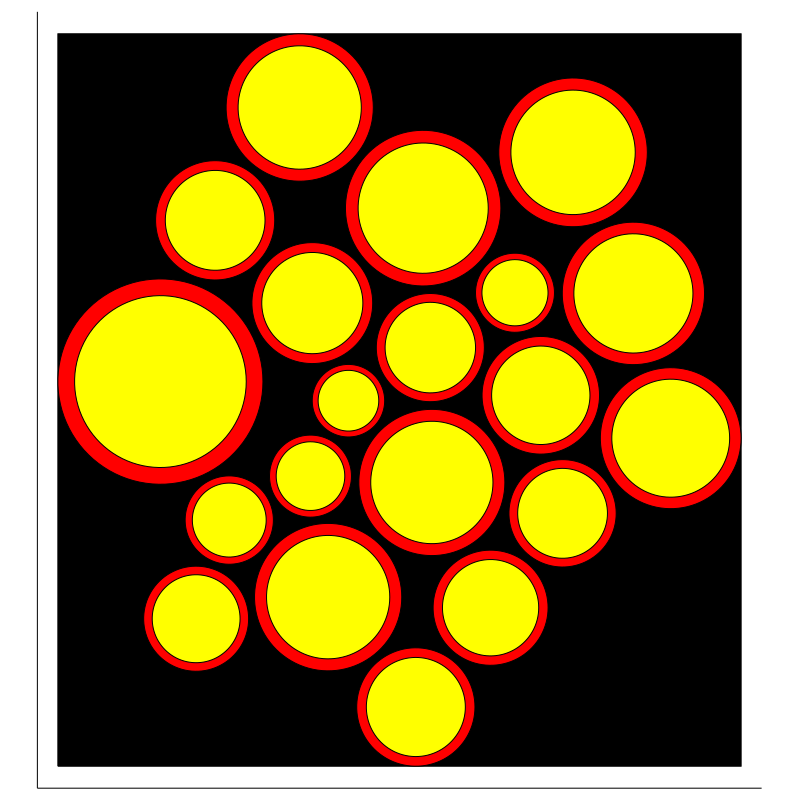

In [7]:
p = plot(bounding_box(circles); color = :black, seriestype = :shape, aspect_ratio = :equal)
for c in circles
    plot!(p, c; color = :red, seriestype = :shape)
    plot!(p, scale_shape(c, btparams.g_ratio); color = :yellow, seriestype = :shape)
end
p

In [25]:
function _disjoint_rect_mesh_with_tori(
        rect_bdry::Rectangle{2,T},
        inner_circles::Vector{Circle{2,T}},
        outer_circles::Vector{Circle{2,T}},
        h_min::T, # minimum edge length
        h_max::T = h_min, # maximum edge length (default to uniform)
        h_range::T = T(10*h_min), # distance over which h increases from h_min to h_max
        h_rate::T = T(0.7); # rate of increase of h from circle boundaries (power law)
        exterior_tiling = (1,1), # tile exterior grid into (m,n) subgrids
        plotgrids = false, # plot resulting grids
        plotgridprogress = false, # plot grids as they are created
        CIRCLESTALLITERS = 1000, # stall iterations for interior/tori grids
        EXTERIORSTALLITERS = 500, # stall iterations for exterior grids
    ) where {T}

    # Useful defines
    V, G = Vec{2,T}, Grid{2,3,T,3}
    D_BDRY = h_min*sqrt(eps(T)) # points within D_BDRY from boundary edges are deemed on the boundary
    D_CIRC = h_min # circles with at least D_CIRC within the bounding box are included

    # Ensure that:
    # -there are the same number of outer/inner circles, and at least 1 of each
    # -outer circles strictly contain inner circles
    # -outer/inner circles have the same origins
    # -outer circles are strictly non-overlapping
    @assert length(inner_circles) == length(outer_circles) >= 1
    @assert all(c -> is_inside(c[1], c[2], <), zip(inner_circles, outer_circles))
    @assert all(c -> origin(c[1]) ≈ origin(c[2]), zip(inner_circles, outer_circles))
    @assert !is_any_overlapping(outer_circles, <)

    function check_include_circle(c)
        # Allow circle if the circle is sufficiently inside the boundary rectangle;
        # here, if intersect(c,rect_bdry) has size above a threshold in all dimensions
        c_bounding_box = intersect(rect_bdry, bounding_box(c))
        return min(widths(c_bounding_box)...) ≥ D_CIRC
    end

    function circle_bdry_points(p::AbstractVector{V}, e, c, thresh = D_BDRY) where {V <: Vec{2}}
        e_unique = unique!(sort!(copy(reinterpret(Int, e)))) # unique indices of boundary points
        p_bdry = filter(x -> is_on_circle(x, c, thresh), p[e_unique]) # keep points which are on `c`
        return p_bdry
    end
    function circle_bdry_points(g::Grid{dim,N,T,M}, c, thresh = D_BDRY) where {dim,N,T,M}
        e_unique = unique!(sort!(copy(reinterpret(Int, boundedges(g)))))
        p_bdry_all = Vec{dim,T}[getcoordinates(getnodes(g)[i]) for i in e_unique]
        p_bdry = filter(x -> is_on_circle(x, c, thresh), p_bdry_all)
        return p_bdry
    end

    # Project points onto circles/boundaries if they are within a distance `thresh`
    function fix_gridpoints!(p, t,
            rect_bdry = rect_bdry,
            inner_circles = inner_circles,
            outer_circles = outer_circles
        )

        e = boundedges(p, t) # vectors of NTuple{2,Int}'s of boundary edge points
        bdry_indices = unique(reinterpret(Int, e)) # boundary point indices
        for i in bdry_indices
            pᵢ = p[i]
            d_in, idx_in = findmin([abs(dcircle(pᵢ, c)) for c in inner_circles])
            d_out, idx_out = findmin([abs(dcircle(pᵢ, c)) for c in outer_circles])
            d_rect = abs(drectangle0(pᵢ, rect_bdry))

            if d_rect ≤ min(d_in, d_out)
                dxL, dxR = abs(pᵢ[1] - xmin(rect_bdry)), abs(pᵢ[1] - xmax(rect_bdry))
                dyL, dyR = abs(pᵢ[2] - ymin(rect_bdry)), abs(pᵢ[2] - ymax(rect_bdry))
                _, idx = findmin((dxL, dxR, dyL, dyR))

                # Project onto nearest rectangle wall
                p[i] = idx == 1 ? V((xmin(rect_bdry), pᵢ[2])) :
                       idx == 2 ? V((xmax(rect_bdry), pᵢ[2])) :
                       idx == 3 ? V((pᵢ[1], ymin(rect_bdry))) :
                                  V((pᵢ[1], ymax(rect_bdry)))
            else
                # Project onto nearest circle
                c = d_in < d_out ? inner_circles[idx_in] : outer_circles[idx_out]
                dx = pᵢ - origin(c)
                p[i] = origin(c) + (radius(c)/norm(dx)) * dx
            end
        end

        return p
    end

    function remove_extra_boundary_points(p, t, p_allowed, p_input, fd, thresh = D_BDRY)
        p_to_remove = filter(x -> !any(norm(x-y) < thresh for y in p_allowed), p_input)
        if !isempty(p_to_remove)
            p = filter(x -> !any(norm(x-y) < thresh for y in p_to_remove), p)
            t = delaunay2(p) # new Delaunay triangulation
            pmid = V[(p[t[1]] + p[t[2]] + p[t[3]])/3 for t in t] # Compute centroids
            t = t[fd.(pmid) .< thresh] # Keep interior triangles
            p, t, _ = fixmesh(p, t)
        end
        return p, t
    end

    # Initialize interior/tori grids
    interiorgrids, torigrids = G[], G[], G[]
    parent_circle_indices = collect(1:length(inner_circles))

    # Initialize exterior grid
    exteriorgrids = Matrix{G}(undef, exterior_tiling)
    tiled_ext_bdry = tile_rectangle(rect_bdry, exterior_tiling)

    # Initialize plot, if any
    local fighandle
    # plotgrids && (fighandle = plot(;seriestype = :simpplot))
    plotgrids && (fighandle = simpplot())

    @inbounds for i = 1:length(inner_circles)
        # Fixed points for inner/outer circles, as well as boundary points
        c_in = inner_circles[i]
        int_bdry = intersect(rect_bdry, bounding_box(c_in))

        println("$i/$(length(inner_circles)): Interior")
        if !check_include_circle(c_in)
            push!(interiorgrids, Grid(Triangle[], Node{2,T}[]))
            continue
        end

        halfwidth = min(radius(c_in)/5, 0.5 * min(widths(int_bdry)...))
        h0 = min(h_min, halfwidth)
        h1 = min((h_max/h_min) * h0, halfwidth) # preserve ratio eta, or clamp
        h2 = h_range # don't want to shrink h_range

        eta = h1/h0
        gamma = h2/h0
        alpha = h_rate

        println("\nDEBUG...")
        @show radius(c_in)
        @show h0, h1, h2
        @show eta, gamma, alpha
        @show length(DistMesh.init_points(mxbbox(int_bdry), h0))

        fd = x -> dintersect(drectangle0(x, int_bdry), dcircle(x, c_in))
        fh = x -> hcircle(x, h0, eta, gamma, alpha, c_in)

        pfix = vcat(
            filter(x -> is_in_circle(x, c_in), [corners(rect_bdry)...]), # rect_bdry corners
            intersection_points(rect_bdry, c_in)
        )
        !isempty(pfix) && unique!(sort!(pfix; by = first))

        p, t = distmesh2d(
            fd, fh, h0, mxbbox(int_bdry), pfix;
            PLOT = plotgridprogress, MAXSTALLITERS = CIRCLESTALLITERS
        )
        fix_gridpoints!(p, t, rect_bdry)

        @show length(p)
        println("...DEBUG\n")

        # Push interior grid, and plot if requested
        push!(interiorgrids, Grid(p, t))
        plotgrids && simpplot!(fighandle, interiorgrids[end]; color = :yellow)
        plotgrids && plot!(fighandle, Circle{2,T}(mean(p), 2*h_min); color = :white, seriestype = :shape, annotations = (mean(p)..., string(i)))
    end

    @inbounds for i = 1:length(outer_circles)
        # Fixed points for inner/outer circles, as well as boundary points
        c_in, c_out = inner_circles[i], outer_circles[i]
        out_bdry = intersect(rect_bdry, bounding_box(c_out))

        println("$i/$(length(outer_circles)): Annular")
        if !check_include_circle(c_out)
            push!(torigrids, Grid(Triangle[], Node{2,T}[]))
            continue
        end
        
        halfwidth = min(0.5 * (radius(c_out) - radius(c_in)), 0.5 * min(widths(out_bdry)...))
        h0 = min(h_min, halfwidth)
        h1 = min((h_max/h_min) * h0, halfwidth) # preserve ratio eta, or clamp
        h2 = h_range # don't want to shrink h_range

        eta = h1/h0
        gamma = h2/h0
        alpha = h_rate

        println("\nDEBUG...")
        @show radius(c_out) - radius(c_in)
        @show h0, h1, h2
        @show eta, gamma, alpha
        @show length(DistMesh.init_points(mxbbox(out_bdry), h0))

        fd = x -> dintersect(drectangle0(x, out_bdry), dshell(x, c_in, c_out))
        fh = x -> hshell(x, h0, eta, gamma, alpha, c_in, c_out)

        pfix_prev = circle_bdry_points(interiorgrids[i], c_in)
        pfix = vcat(
            filter(x -> is_in_circle(x, c_out) && !is_in_circle(x, c_in), [corners(rect_bdry)...]), # rect_bdry corners
            intersection_points(rect_bdry, c_out), # only fix w.r.t rect_bdry to avoid tangent points being fixed
            pfix_prev # interior circle boundary points from inner grid
        )
        !isempty(pfix) && unique!(sort!(pfix; by = first))

        p, t = distmesh2d(
            fd, fh, h0, mxbbox(out_bdry), pfix;
            PLOT = plotgridprogress, MAXSTALLITERS = CIRCLESTALLITERS
        )
        fix_gridpoints!(p, t, rect_bdry)

        pfix_now = circle_bdry_points(p, boundedges(p,t), c_in)
        p, t = remove_extra_boundary_points(p, t, pfix_prev, pfix_now, fd)

        @show length(p)
        println("...DEBUG\n")

        # Push tori grid, and plot if requested
        push!(torigrids, Grid(p, t)) #push!(torigrids, Grid(p, t, e))
        plotgrids && simpplot!(fighandle, torigrids[end]; color = :blue)
    end

    for i in 1:exterior_tiling[1]
        for j in 1:exterior_tiling[2]
            # Get current exterior boundary
            ext_bdry = tiled_ext_bdry[i,j]

            # Fixed boundary points are those to the left/below current grid
            boundary_points_below_and_left = (p) -> begin
                p_bdry = V[]
                (j > 1) && (p_bdry = vcat(p_bdry, filter(x -> x[1] ≈ xmax(tiled_ext_bdry[i,j-1]), p)))
                (i > 1) && (p_bdry = vcat(p_bdry, filter(x -> x[2] ≈ ymax(tiled_ext_bdry[i-1,j]), p)))
                !isempty(p_bdry) && unique!(sort!(p_bdry; by = first))
                return p_bdry
            end

            fixed_boundary_points_below_and_left = () -> begin
                p_bdry = V[]
                (j > 1) && (p_bdry = vcat(p_bdry, boundary_points_below_and_left(getcoordinates.(getnodes(exteriorgrids[i,j-1])))))
                (i > 1) && (p_bdry = vcat(p_bdry, boundary_points_below_and_left(getcoordinates.(getnodes(exteriorgrids[i-1,j])))))
                !isempty(p_bdry) && unique!(sort!(p_bdry; by = first))
                return p_bdry
            end

            # Create Delaunay tessellation
            println("$i/$(exterior_tiling[1]), $j/$(exterior_tiling[2]): Exterior")
            h0 = h_min
            eta = h_max/h_min
            gamma = h_range/h_min
            alpha = h_rate
            
            fd = x -> dexterior(x, ext_bdry, outer_circles)
            fh = x -> hcircles(x, h0, eta, gamma, alpha, outer_circles)

            pfix_prev = vcat(
                fixed_boundary_points_below_and_left(), # fixed points from previous domain
                reduce(vcat, circle_bdry_points(torigrids[i], c_out) for (i, c_out) in enumerate(outer_circles)) # boundary points from outer circles
            )
            pfix = vcat(
                filter(x -> !is_in_any_circle(x, outer_circles), [corners(ext_bdry)...]), # ext_bdry corners, if not in an outer_circle
                pfix_prev
            )
            !isempty(pfix) && unique!(sort!(filter!(p->is_inside(p, ext_bdry), pfix); by = first))

            p, t = distmesh2d(
                fd, fh, h0, mxbbox(ext_bdry), pfix;
                PLOT = plotgridprogress, MAXSTALLITERS = EXTERIORSTALLITERS
            )
            fix_gridpoints!(p, t, ext_bdry)

            e = boundedges(p,t)
            pfix_now = reduce(vcat, circle_bdry_points(p, e, c_out) for c_out in outer_circles)
            p, t = remove_extra_boundary_points(p, t, pfix_prev, pfix_now, fd)

            # Form exterior grid, and plot if requested
            exteriorgrids[i,j] = Grid(p, t)
            plotgrids && simpplot!(fighandle, exteriorgrids[i,j]; color = :cyan)
        end
    end

    # Plot resulting grid
    plotgrids && display(fighandle)

    return exteriorgrids, torigrids, interiorgrids, parent_circle_indices
end

_disjoint_rect_mesh_with_tori (generic function with 4 methods)

In [32]:
function creategeometry(btparams::BlochTorreyParameters{T};
        fname = nothing, # filename for saving
        N = 20, # number of circles
        η = btparams.AxonPDensity, # goal packing density
        ϵ = 0.1 * btparams.R_mu, # overlap occurs when distance between circle edges is ≤ ϵ
        outercircles = packcircles(btparams; N=N,η=η,ϵ=ϵ,α=1e-1,β=1e-6,λ=1.0,it=100), # outer circles
        bdry = opt_subdomain(outercircles)[1], # default boundary is automatically determined in packcircles
        RESOLUTION = 1.0,
        CIRCLESTALLITERS = 1000, #DEBUG
        EXTERIORSTALLITERS = 1000, #DEBUG
        PLOT = true
    ) where {T}
    
    mindist = minimum_signed_edge_distance(outercircles)
    h_min = RESOLUTION * T(0.5 * mindist)
    h_max = RESOLUTION * T(1.0 * mindist)
    h_range = RESOLUTION * T(2.0 * mindist)
    h_rate = T(1.0)

    innercircles = scale_shape.(outercircles, btparams.g_ratio)

    @time exteriorgrids, torigrids, interiorgrids, parentcircleindices = _disjoint_rect_mesh_with_tori(
        bdry, innercircles, outercircles, h_min, h_max, h_range, h_rate;
        plotgrids = PLOT, exterior_tiling = (1, 1), # DEBUG
        CIRCLESTALLITERS = CIRCLESTALLITERS, EXTERIORSTALLITERS = EXTERIORSTALLITERS
    )

    cell_area_mismatch = sum(area.(exteriorgrids)) + sum(area.(torigrids)) + sum(area.(interiorgrids)) - area(bdry)
    @show cell_area_mismatch

#     PLOT && simpplot(vcat(exteriorgrids[:], torigrids[:], interiorgrids[:]); newfigure = true, axis = mxaxis(bdry))
#     PLOT && simpplot(vcat(exteriorgrids[:], torigrids[:], interiorgrids[:]); color = :cyan) |> display
#     !(fname == nothing) && mxsavefig(fname) #DEBUG

    return exteriorgrids, torigrids, interiorgrids, outercircles, innercircles, bdry
end

creategeometry (generic function with 1 method)

In [ ]:
exteriorgrids, torigrids, interiorgrids, outercircles, innercircles, bdry = creategeometry(btparams;
    N = 50, PLOT = true
);


Packing... (attempt 1/5)

GreedyCirclePacking:   0.296027 seconds (15.50 k allocations: 377.031 KiB)
EnergyCirclePacking:   2.877784 seconds (1.43 M allocations: 66.991 MiB, 1.67% gc time)

Distance threshold: 0.046000000000000006
Minimum myelin thickness: 0.014106740645953223
Minimum circles distance: 0.05756185266389138

GreedyCirclePacking density:  0.8186189609022231
EnergyCirclePacking density:  0.7832650072749557
Final scaled circles density: 0.7499999999999999
1/50: Interior

DEBUG...
radius(c_in) = 0.5011562770455062
(h0, h1, h2) = (0.02878092633194569, 0.05756185266389138, 0.11512370532778277)
(eta, gamma, alpha) = (2.0, 4.0, 1.0)
length(DistMesh.init_points(mxbbox(int_bdry), h0)) = 1435
length(p) = 456
...DEBUG

2/50: Interior

DEBUG...
radius(c_in) = 0.36087963758696695
(h0, h1, h2) = (0.02878092633194569, 0.05756185266389138, 0.11512370532778277)
(eta, gamma, alpha) = (2.0, 4.0, 1.0)
length(DistMesh.init_points(mxbbox(int_bdry), h0)) = 754
length(p) = 245
...DEBUG

3/50: I

length(p) = 183
...DEBUG

33/50: Interior
34/50: Interior

DEBUG...
radius(c_in) = 0.44425355646602194
(h0, h1, h2) = (0.02878092633194569, 0.05756185266389138, 0.11512370532778277)
(eta, gamma, alpha) = (2.0, 4.0, 1.0)
length(DistMesh.init_points(mxbbox(int_bdry), h0)) = 324
length(p) = 118
...DEBUG

35/50: Interior
36/50: Interior
37/50: Interior

DEBUG...
radius(c_in) = 0.30898287032642247
(h0, h1, h2) = (0.02878092633194569, 0.05756185266389138, 0.11512370532778277)
(eta, gamma, alpha) = (2.0, 4.0, 1.0)
length(DistMesh.init_points(mxbbox(int_bdry), h0)) = 550
length(p) = 190
...DEBUG

38/50: Interior

DEBUG...
radius(c_in) = 0.223432095432178
(h0, h1, h2) = (0.02878092633194569, 0.0446864190864356, 0.11512370532778277)
(eta, gamma, alpha) = (1.552640056509767, 4.0, 1.0)
length(DistMesh.init_points(mxbbox(int_bdry), h0)) = 198
length(p) = 117
...DEBUG

39/50: Interior

DEBUG...
radius(c_in) = 0.3330100608804127
(h0, h1, h2) = (0.02878092633194569, 0.05756185266389138, 0.115123705327

length(p) = 87
...DEBUG

20/50: Annular

DEBUG...
radius(c_out) - radius(c_in) = 0.049997973149239316
(h0, h1, h2) = (0.024998986574619658, 0.024998986574619658, 0.11512370532778277)
(eta, gamma, alpha) = (1.0, 4.60513489153447, 1.0)
length(DistMesh.init_points(mxbbox(out_bdry), h0)) = 725
length(p) = 193
...DEBUG

21/50: Annular

DEBUG...
radius(c_out) - radius(c_in) = 0.10378518255962388
(h0, h1, h2) = (0.02878092633194569, 0.05189259127981194, 0.11512370532778277)
(eta, gamma, alpha) = (1.8030201905702115, 4.0, 1.0)
length(DistMesh.init_points(mxbbox(out_bdry), h0)) = 780
length(p) = 234
...DEBUG

22/50: Annular

DEBUG...
radius(c_out) - radius(c_in) = 0.05818719976824327
(h0, h1, h2) = (0.02878092633194569, 0.029093599884121635, 0.11512370532778277)
(eta, gamma, alpha) = (1.0108639155171628, 4.0, 1.0)
length(DistMesh.init_points(mxbbox(out_bdry), h0)) = 725
length(p) = 213
...DEBUG

23/50: Annular

DEBUG...
radius(c_out) - radius(c_in) = 0.06936907424894545
(h0, h1, h2) = (0.028780